<a href="https://colab.research.google.com/github/Henil21/Intro_to_computer_vision_and_CNN/blob/main/Transfer_learning_Fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# !nvidia-smi

# **Fine-Tuning🌻**


## Lets get some data
How we can use the pretrained models within `tf.keras.applications` and apply them to our own problem (recognizing images of food).

#importing Helper function

In [3]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py 

# Import helper functions we're going to use
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

--2022-12-15 11:19:59--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-12-15 11:19:59 (107 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip 

unzip_data("10_food_classes_10_percent.zip")

--2022-12-15 11:20:00--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.128, 142.250.4.128, 142.251.10.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  23.8MB/s    in 7.8s    

2022-12-15 11:20:08 (20.5 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [6]:
train_dir="10_food_classes_10_percent/train"
test_dir="10_food_classes_10_percent/test"

In [7]:
import tensorflow as tf
IMG_SIZE=(224,224)
Batch_size=32
train_data=tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                      image_size=IMG_SIZE,
                                                                      label_mode="categorical",
                                                                      batch_size=Batch_size)
test_data=tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                      image_size=IMG_SIZE,
                                                                      label_mode="categorical",
                                                                      batch_size=Batch_size)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [10]:
train_data.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

## Model 0: Building transfer learning model using the keras `Functional API`

>The functional API gives us flexibility with our model


Keras Applications are premade architectures with pre-trained weights.

In [18]:
#1 we are using include_top=false beacuse its top layers has 1k output layers 
base_model=tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model
base_model.trainable=False

#3. Create inputs into out model
inputs=tf.keras.layers.Input(shape=(224,224,3),name='input_layer')

# 4. if using like ResNet50V2 you will need to normalize inputs (we dont need for EfficientNet it has built in)
# x= tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. passing input to the base_model
x=base_model(inputs)
print(f"shape after passing inputs through base model:{x.shape}")

# 6.Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x=tf.keras.layers.GlobalAveragePooling2D(name='global_avg_pooling_layer')(x)
print(f"shape after passing inputs through global_avg_pooling_layer:{x.shape}")

# 7. Create the Output activation layer
output=tf.keras.layers.Dense(10,activation="softmax",name="output_layer")(x)

# 8. Compile for the model
model_0=tf.keras.Model(inputs,output)
model_0.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
history_1=model_0.fit(train_data,
                      epochs=5,
                      steps_per_epoch=len(train_data),
                      validation_data=test_data,
                      validation_steps=len(test_data),
                      callbacks=create_tensorboard_callback(dir_name="transfer_learning", experiment_name="10_percent_feature_extraction"))

shape after passing inputs through base model:(None, 7, 7, 1280)
shape after passing inputs through global_avg_pooling_layer:(None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20221215-123921
Epoch 1/5
24/24 [==============================] - 16s 431ms/step - loss: 1.8232 - accuracy: 0.4293 - val_loss: 1.2366 - val_accuracy: 0.7644
Epoch 2/5
24/24 [==============================] - 8s 329ms/step - loss: 1.0742 - accuracy: 0.7587 - val_loss: 0.8396 - val_accuracy: 0.8304
Epoch 3/5
24/24 [==============================] - 8s 331ms/step - loss: 0.7772 - accuracy: 0.8293 - val_loss: 0.6775 - val_accuracy: 0.8516
Epoch 4/5
24/24 [==============================] - 8s 328ms/step - loss: 0.6391 - accuracy: 0.8573 - val_loss: 0.6000 - val_accuracy: 0.8564
Epoch 5/5
24/24 [==============================] - 8s 323ms/step - loss: 0.5400 - accuracy: 0.8840 - val_loss: 0.5492 - val_accuracy: 0.8600


In [19]:
model_0.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pooling_layer (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


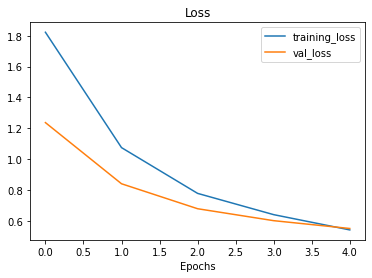

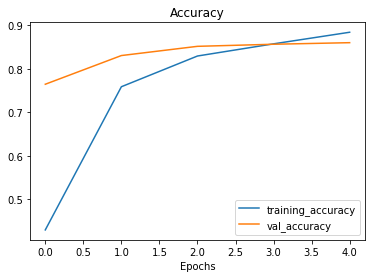

In [20]:
plot_loss_curves(history_1)